In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import os
from collections import namedtuple
sys.path.append('C:\\Users\\philip.remes\\OneDrive - Thermo Fisher Scientific\\Documents\\Software\\Jupyter\\PythonUtilities\\')
import utilities_pmr as pmr
colors = pmr.setup_environment()
import analyze_ratios as ar

plot_markers, plot_colors = ['o', 'v', 'o', 'v', 'o', 'v'], [colors[0], colors[0], colors[1], colors[1], colors[2], colors[2]]

Load the Skyline transition results, and a mapping of file name to concentration

In [2]:
FileInfo = namedtuple('FileInfo', ['condition', 'trans_results_file', 'rep_to_conc_file'])

file_info = [
    FileInfo('Peptide Level DIA', 
             '230208_p2_neo_30min_DIA_peplevel_opt_trans_results.csv', 
             '230208_p2_neo_30min_DIA_peplevel_file_conc.csv'),
    
    FileInfo('Plasma Level DIA', 
             '230208_p2_neo_30min_DIA_plasmalevel_opt_trans_results.csv', 
             '230208_p2_neo_30min_DIA_plasmalevel_file_conc.csv'),
    
    FileInfo('Peptide Level Big', 
             '230124_p2_neo_30min_3500targets_opt_trans_pepleveldilution_trans_results.csv', 
             '230124_p2_neo_30min_3500targets_pepleveldilution_file_conc.csv'),  

    FileInfo('Plasma Level Big', 
             '230203_p2_neo_30min_3500targets_opt_trans_plasmaleveldilution_trans_results.csv', 
             '230203_p2_neo_30min_3500targets_plasmaleveldilution_file_conc.csv'),
    
    FileInfo('Peptide Level Small', 
             '230127_p2_neo_30min_1599targets_opt_trans_pepleveldilution_trans_results.csv', 
             '230127_p2_neo_30min_1599targets_pepleveldilution_file_conc.csv'),

    FileInfo('Plasma Level Small', 
             '230203_p2_neo_30min_1699targets_opt_trans_plasmaleveldilution_trans_results.csv', 
             '230203_p2_neo_30min_1699targets_plasmaleveldilution_file_conc.csv'),
]

data = [ar.load_results(info) for info in file_info]

Load info for 230208_p2_neo_30min_DIA_peplevel_opt_trans_results.csv
Load info for 230208_p2_neo_30min_DIA_plasmalevel_opt_trans_results.csv
Load info for 230124_p2_neo_30min_3500targets_opt_trans_pepleveldilution_trans_results.csv
Load info for 230203_p2_neo_30min_3500targets_opt_trans_plasmaleveldilution_trans_results.csv
Load info for 230127_p2_neo_30min_1599targets_opt_trans_pepleveldilution_trans_results.csv
Load info for 230203_p2_neo_30min_1699targets_opt_trans_plasmaleveldilution_trans_results.csv


## Linearity of the measurements
Scatter plots of the ratio of the area at a particular concentration, to the area at 100% human.  The red horizontal dotted lines depict a bounds around the expected ratio.

    - Notice how a lot of the homologous peptides with chicken at the highest concentration are filtered out at the 1599 assay

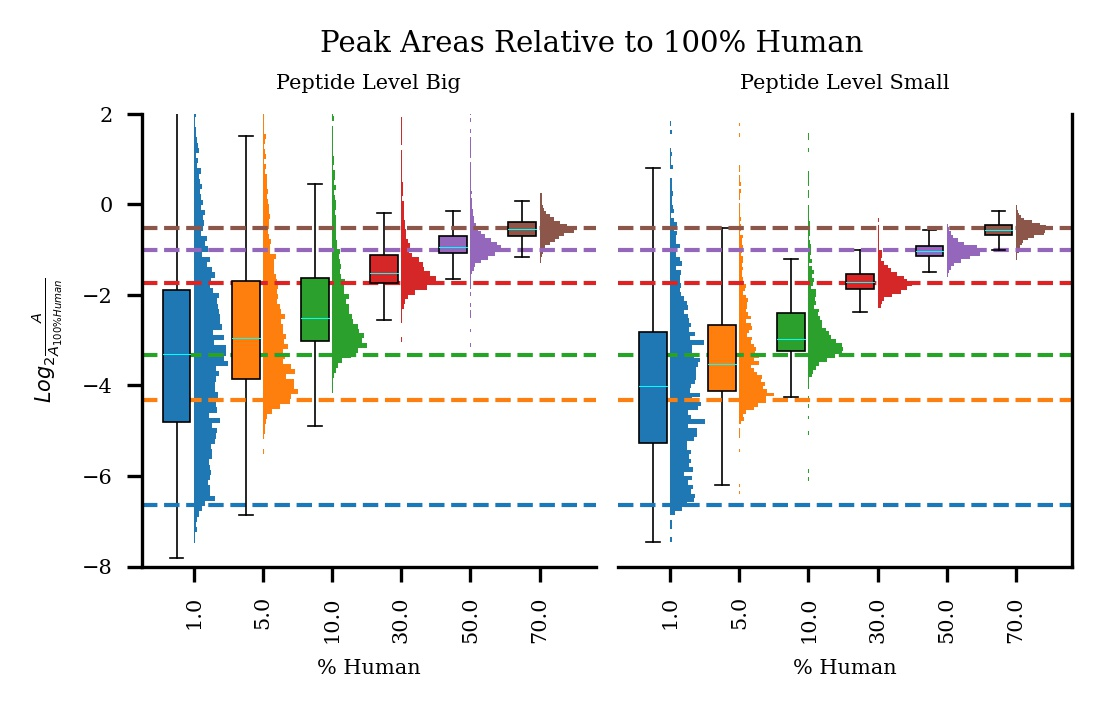

In [15]:
def plot_bars_ratios(data_sets, concentrations, titles):
    num_axes = len(data_sets)
    fig,axes = plt.subplots(1, num_axes, sharey=True, figsize=(4, 2))
    fig.suptitle('Peak Areas Relative to 100% Human', y=1.02)
    fig.subplots_adjust(wspace=0.05)
    num_plots = len(concentrations)-1
    indices_to_plot = [5, 7, 9, 10, 11, 12]    
    for pidx,(ratios_vs_intensity,ax, title) in enumerate(zip(data_sets, axes, titles)):
    
        for xidx,idx in enumerate(indices_to_plot):
            intensities_for_conc,ratios_for_conc = [],[]
            for item in ratios_vs_intensity:
                if idx < len(item['ratios']):
                    intensities_for_conc.append(item['inten'])
                    ratios_for_conc.append(item['ratios'][idx])

            ratios_for_conc = [np.log2(x) for x in ratios_for_conc]    
            medianprops = dict(linestyle='-', linewidth=0.25, color='cyan')
            boxprops = dict(linestyle='-', linewidth=0.4)
            whiskerprops=dict(linewidth=0.4)
            capprops=dict(linewidth=0.4)
            bplots = ax.boxplot(
                ratios_for_conc, medianprops=medianprops, capprops=capprops,
                boxprops=boxprops, whiskerprops=whiskerprops,
                positions=[xidx-0.25], showfliers=False, patch_artist=True, widths=0.4)
            
            expected_ratio = concentrations[idx] / concentrations[-1]
            if expected_ratio > 0.0:
                expected_ratio_log2 = np.log2(expected_ratio)        
                ax.axhline(y=expected_ratio_log2, linestyle='--', color=colors[xidx])
                box_color = colors[xidx]
            else:
                box_color = 'grey'

            for patch in bplots['boxes']:
                patch.set_facecolor(box_color)
                
            # histogram plot of the ratios
            hist,bins = np.histogram(ratios_for_conc, 128)
            weights = np.ones_like(ratios_for_conc)/np.max(hist) * 0.5
            ax.hist(ratios_for_conc, 128, bottom=xidx, orientation='horizontal', weights=weights)

            xaxis = np.arange(len(indices_to_plot))
            labels = [concentrations[x] for x in indices_to_plot]
            
        ax.set_title(title)
        ax.set_xticks(xaxis)
        ax.set_xticklabels(labels, rotation=90)
        ax.set_ylim(-8, 2)
        ax.set_xlabel('% Human')
        ax.spines[['top']].set_visible(False)
        if pidx == 0:
            ax.set_ylabel('$Log_{2} \\frac{A}{A_{100\% Human}}$')
        if pidx < num_axes-1:
            ax.spines[['right']].set_visible(False)
        if pidx > 0:
            ax.spines[['left']].set_visible(False)
        if pidx > 0:
            ax.tick_params(labelleft=False, left=False)

indices_to_plot = [2, 4]
data_to_plot = [data[x][0] for x in indices_to_plot]
info_to_plot = [file_info[x].condition for x in indices_to_plot]
plot_bars_ratios(data_to_plot, data[0][1], info_to_plot)        


## Summary of Precision Results


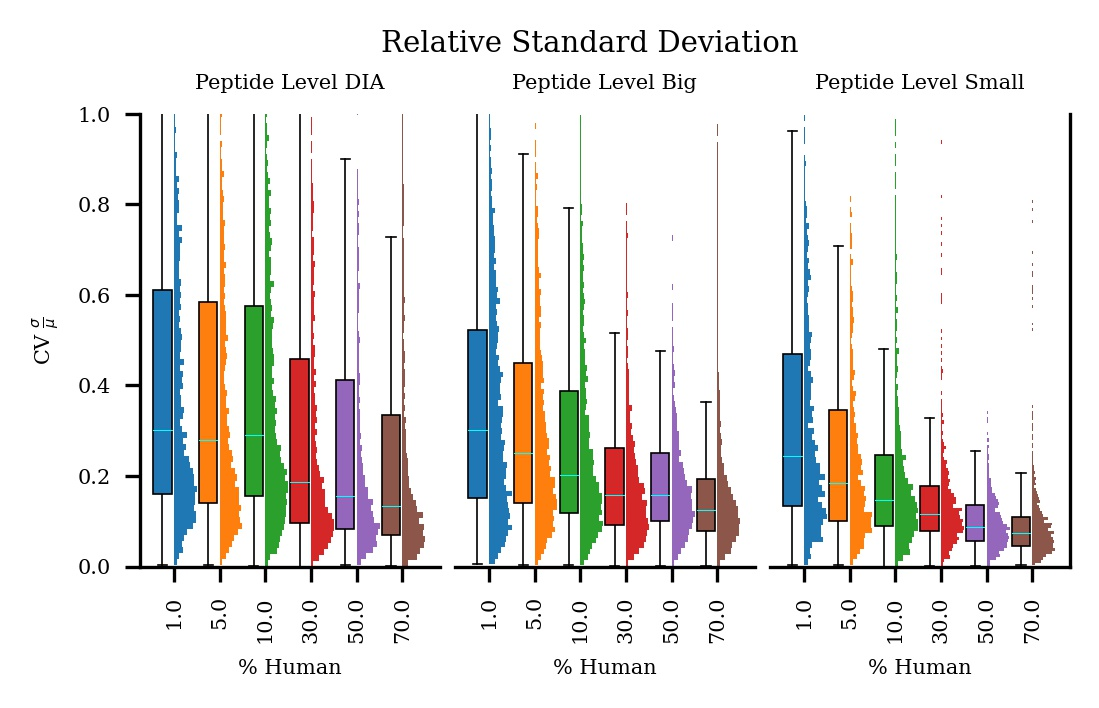

In [12]:
def plot_bars_rsds(data_sets, concentrations, titles):
    num_axes = len(data_sets)
    fig,axes = plt.subplots(1, num_axes, sharey=True, figsize=(4, 2))
    fig.suptitle('Relative Standard Deviation', y=1.02)
    fig.subplots_adjust(wspace=0.05)
    num_plots = len(concentrations)-1
    indices_to_plot = [5, 7, 9, 10, 11, 12]    
    for pidx,(ratios_vs_intensity,ax, title) in enumerate(zip(data_sets, axes, titles)):
    
        for xidx,idx in enumerate(indices_to_plot):
            values_for_conc = []
            for item in ratios_vs_intensity:
                if idx < len(item['rsds']):
                    values_for_conc.append(item['rsds'][idx])
   
            medianprops = dict(linestyle='-', linewidth=0.25, color='cyan')
            boxprops = dict(linestyle='-', linewidth=0.4)
            whiskerprops=dict(linewidth=0.4)
            capprops=dict(linewidth=0.4)
            bplots = ax.boxplot(
                values_for_conc, medianprops=medianprops, capprops=capprops,
                boxprops=boxprops, whiskerprops=whiskerprops,
                positions=[xidx-0.25], showfliers=False, patch_artist=True, widths=0.4)
            
            for patch in bplots['boxes']:
                patch.set_facecolor(colors[xidx])
                
            # histogram plot of the ratios
            hist,bins = np.histogram(values_for_conc, 128)
            weights = np.ones_like(values_for_conc)/np.max(hist) * 0.5
            ax.hist(values_for_conc, 128, bottom=xidx, orientation='horizontal', weights=weights)

            xaxis = np.arange(len(indices_to_plot))
            labels = [concentrations[x] for x in indices_to_plot]
            
        ax.set_ylim(0, 1)
        ax.set_title(title)
        ax.set_xticks(xaxis)
        ax.set_xticklabels(labels, rotation=90)
        ax.set_xlabel('% Human')
        ax.spines[['top']].set_visible(False)
        if pidx == 0:
            ax.set_ylabel('CV $\\frac{\sigma}{\mu}$')
        if pidx < num_axes-1:
            ax.spines[['right']].set_visible(False)
        if pidx > 0:
            ax.spines[['left']].set_visible(False)
        if pidx > 0:
            ax.tick_params(labelleft=False, left=False)

indices_to_plot = [0, 2, 4]
data_to_plot = [data[x][0] for x in indices_to_plot]
info_to_plot = [file_info[x].condition for x in indices_to_plot]
plot_bars_rsds(data_to_plot, data[0][1], info_to_plot)        


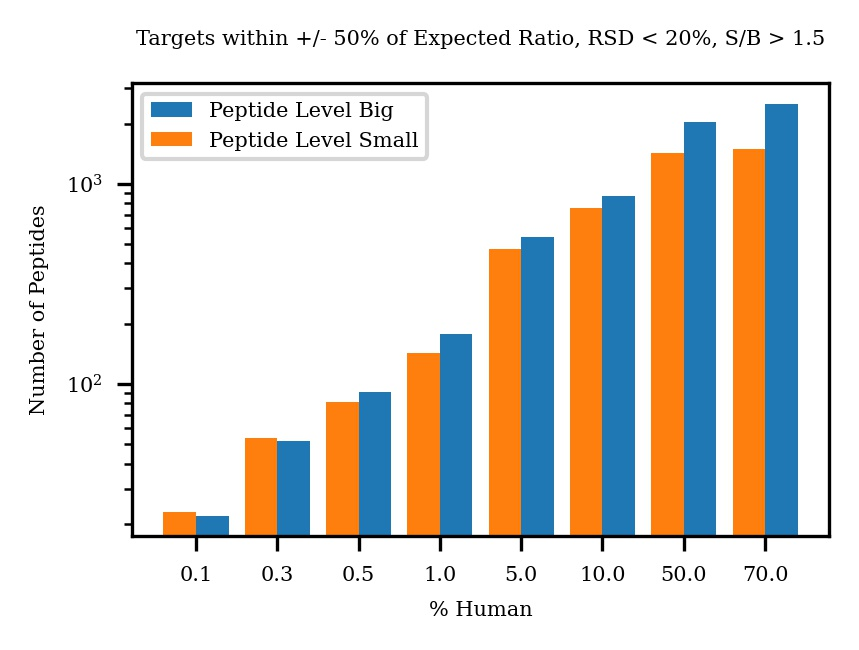

In [6]:
def plot_num_good_sb(data_sets, concentrations, titles):
    fig,ax = plt.subplots(1)
    num_plots = len(concentrations)-1
    indices_to_plot = [1, 2, 3, 5, 7, 9, 11, 12]   
    
    number_for_conc = []
    for datum in data_sets:
        pcts = ar.get_data_for_ratio_rsd_sb_in_bounds(datum, concentrations)
        nums = [x * len(datum)/100 for x in pcts]
        number_for_conc.append(nums)
        
    for pidx,(numbers, title) in enumerate(zip(number_for_conc, titles)):
        
        data_to_plot = [numbers[i] for i in indices_to_plot]
        xaxis = np.arange(len(data_to_plot))
        width = 0.4
        offset = -width/2 + width*pidx
        ax.bar(xaxis - offset, data_to_plot, width=width, label=title)
    ax.legend()
    ax.set_xticks(xaxis)
    ax.set_xticklabels([concentrations[i] for i in indices_to_plot])
    ax.set_yscale('log')
    ax.set_ylabel('Number of Peptides')
    ax.set_xlabel('% Human')
    ax.set_title(f'Targets within +/- {(ar.BOUNDS_MULT-1.0)*100:.0f}% of Expected Ratio, RSD < 20%, S/B > {ar.SB_LIMIT:.1f}', y=1.03)
     
plot_num_good_sb(data_to_plot, data[0][1], info_to_plot)

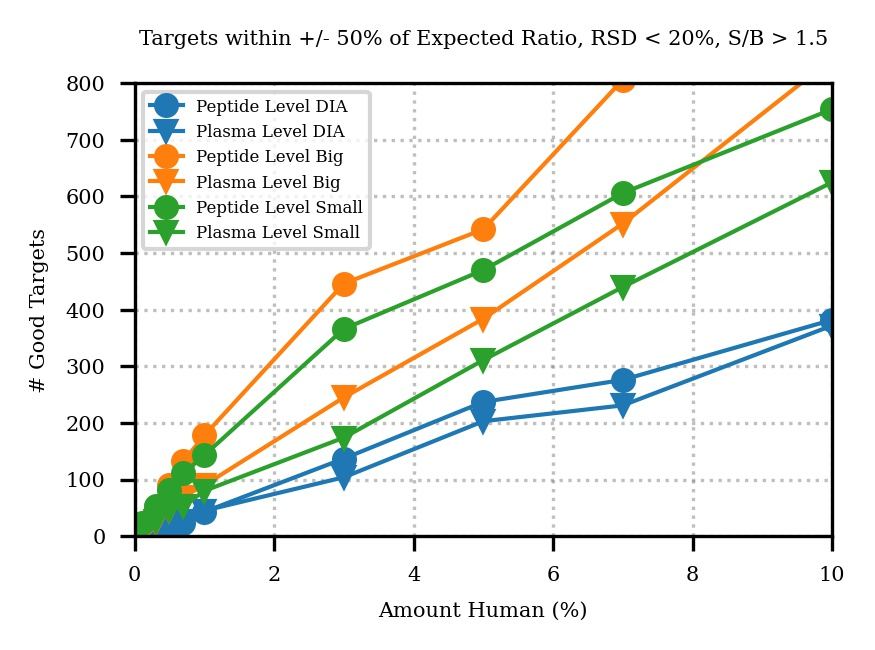

In [7]:
def plot_num_good_sb(data, file_info, markers, colors, xlabel='Amount Human (%)'):
    fig,ax = plt.subplots()
    ax.set_title(f'Targets within +/- {(ar.BOUNDS_MULT-1.0)*100:.0f}% of Expected Ratio, RSD < 20%, S/B > {ar.SB_LIMIT:.1f}', y=1.03)
    for datum,info,marker,color in zip(data, file_info, markers, colors):
        concentrations = datum[1]
        pcts = ar.get_data_for_ratio_rsd_sb_in_bounds(datum[0], concentrations)
        nums = [x * len(datum[0])/100 for x in pcts]

        ax.plot(concentrations[:-1], nums, label=info.condition, marker=marker, color=color)
        ax.legend(fontsize=4)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('# Good Targets')
        ax.grid(True, linestyle=':', color='grey', alpha=0.5)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 800)

plot_num_good_sb(data, file_info, plot_markers, plot_colors);

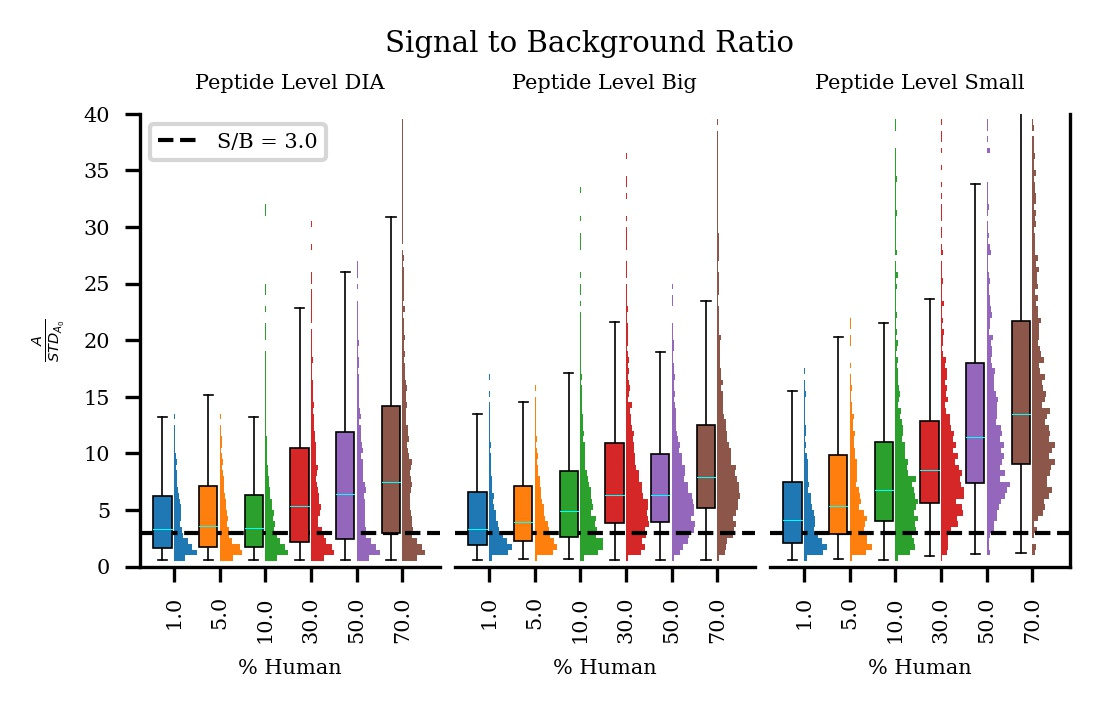

In [8]:
def plot_bars_sbs(data_sets, concentrations, titles):
    num_axes = len(data_sets)
    fig,axes = plt.subplots(1, num_axes, sharey=True, figsize=(4, 2))
    fig.suptitle('Signal to Background Ratio', y=1.02)
    fig.subplots_adjust(wspace=0.05)
    num_plots = len(concentrations)-1
    indices_to_plot = [5, 7, 9, 10, 11, 12]    
    for pidx,(ratios_vs_intensity,ax, title) in enumerate(zip(data_sets, axes, titles)):
    
        for xidx,idx in enumerate(indices_to_plot):
            values_for_conc = []
            for item in ratios_vs_intensity:
                if idx < len(item['sbs']):
                    values_for_conc.append(item['sbs'][idx])
   
            medianprops = dict(linestyle='-', linewidth=0.25, color='cyan')
            boxprops = dict(linestyle='-', linewidth=0.4)
            whiskerprops=dict(linewidth=0.4)
            capprops=dict(linewidth=0.4)
            bplots = ax.boxplot(
                values_for_conc, medianprops=medianprops, capprops=capprops,
                boxprops=boxprops, whiskerprops=whiskerprops,
                positions=[xidx-0.25], showfliers=False, patch_artist=True, widths=0.4)
            
            for patch in bplots['boxes']:
                patch.set_facecolor(colors[xidx])
                
            # histogram plot of the ratios
            max_bin = 40
            hist,bins = np.histogram(values_for_conc, bins=np.arange(0, max_bin, 0.5))
            weights = np.ones_like(values_for_conc)/np.max(hist) * 0.5
            ax.hist(values_for_conc, bins=np.arange(0, max_bin, 0.5), bottom=xidx, orientation='horizontal', weights=weights)

            xaxis = np.arange(len(indices_to_plot))
            labels = [concentrations[x] for x in indices_to_plot]
            
        ax.set_ylim(0, max_bin)
        ax.set_title(title)
        ax.set_xticks(xaxis)
        ax.set_xticklabels(labels, rotation=90)
        ax.set_xlabel('% Human')
        ax.spines[['top']].set_visible(False)
        if pidx == 0:
            ax.set_ylabel('$\\frac{A}{STD_{A_{0}}}$')
        if pidx < num_axes-1:
            ax.spines[['right']].set_visible(False)
        if pidx > 0:
            ax.spines[['left']].set_visible(False)
        if pidx > 0:
            ax.tick_params(labelleft=False, left=False)
        sb_thresh = 3.0
        ax.axhline(y=sb_thresh, linestyle='--', color='k', label=f'S/B = {sb_thresh}')
        if pidx == 0:
            ax.legend(loc='upper left')
        
indices_to_plot = [0, 2, 4]
data_to_plot = [data[x][0] for x in indices_to_plot]
info_to_plot = [file_info[x].condition for x in indices_to_plot]
plot_bars_sbs(data_to_plot, data[0][1], info_to_plot)        


In [9]:
def plot_bars_loqs(data_sets):
    num_axes = len(data_sets)
    fig,ax = plt.subplots()
    fig.suptitle('Limits of Quantitation', y=1.02)
    fig.subplots_adjust(wspace=0.05)
       
    for xidx,data in enumerate(data_sets):
        loqs = [x['loq'] for x in data]
        
        hist,_ = np.histogram(loqs, bins=bins)
        weights = np.ones_like(loqs)/np.max(hist) * 0.9
        ax.hist(loqs, bins=bins, bottom=xidx, orientation='horizontal', weights=weights)
        ax.set_yscale('log')
        
plot_bars_loqs(quant_info_for_experiments[2:])

NameError: name 'quant_info_for_experiments' is not defined

In [10]:
df = pd.read_csv('230124_p2_neo_30min_3500_targets_opt_trans_pepleveldilution_loqs.csv')
df.head()

,Protein,Peptide Modified Sequence,Limit Of Detection,Limit Of Quantification
0,sp|P02749|APOH_HUMAN,TFYEPGEEITYSC[+57]KPGYVSR,0.100,30.0
1,sp|P02749|APOH_HUMAN,VC[+57]PFAGILENGAVR,5.000,100.0
2,sp|P02749|APOH_HUMAN,ATVVYQGER,0.100,30.0
3,sp|P02749|APOH_HUMAN,EHSSLAFWK,12.171,30.0
4,sp|O15143|ARC1B_HUMAN,TQIAIC[+57]PNNHEVHIYEK,0.300,30.0


[Text(0, 0, '0.1'),
 Text(1, 0, '0.3'),
 Text(2, 0, '0.5'),
 Text(3, 0, '0.7'),
 Text(4, 0, '1.0'),
 Text(5, 0, '3.0'),
 Text(6, 0, '5.0'),
 Text(7, 0, '7.0'),
 Text(8, 0, '10.0'),
 Text(9, 0, '30.0'),
 Text(10, 0, '50.0'),
 Text(11, 0, '70.0'),
 Text(12, 0, '100.0')]

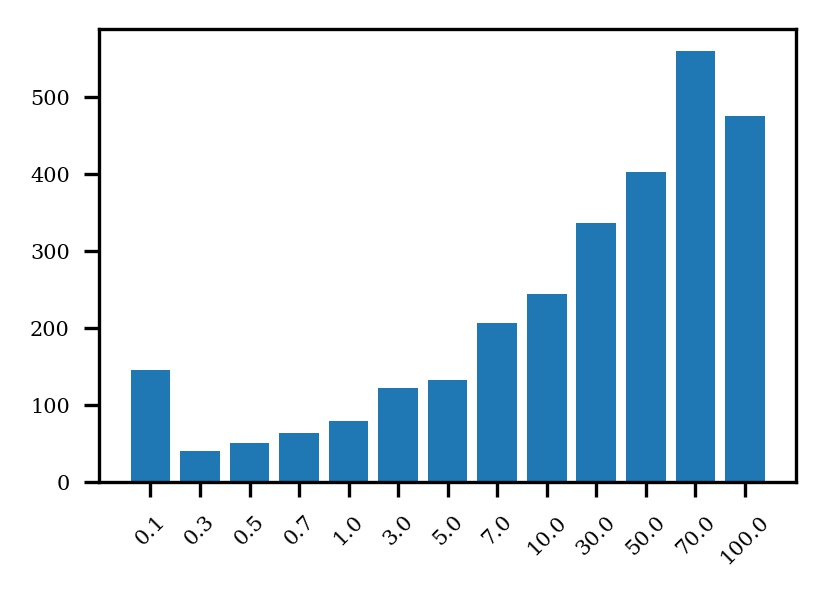

In [11]:
counts = df['Limit Of Quantification'].value_counts()
counts = counts.sort_index()
fig,ax = plt.subplots()
xaxis = np.arange(len(counts.values))
ax.bar(xaxis, counts.values);
ax.set_xticks(xaxis)
ax.set_xticklabels(counts.index, rotation=45)